In [477]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from tqdm import tqdm
import networkx as nx

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'B61'
COLUMNS = ['route', 'x', 'latitude', 'longitude', 'bus_id', 'datetime']

In [3]:
bus_df = pd.read_csv(f'{DATA_DIR}/MTA-Bus-2021-7-5.csv', names=COLUMNS)
bus_gdf = gpd.GeoDataFrame(bus_df, geometry=gpd.points_from_xy(bus_df['longitude'], bus_df['latitude'])).set_crs(CRS_PLOT)

In [37]:
b_gdf = bus_gdf[(bus_gdf['route'].str.contains(ROUTE))]
b_gdf.head()

,route,x,latitude,longitude,bus_id,datetime,geometry
390,MTA NYCT_B61,1,40.689148,-73.990646,MTA NYCT_236,Sun Jul 04 23:43:50 CST 2021,POINT (-73.99065 40.68915)
898,MTA NYCT_B61,1,40.673813,-74.004936,MTA NYCT_410,Sun Jul 04 23:44:32 CST 2021,POINT (-74.00494 40.67381)
954,MTA NYCT_B61,1,40.657711,-73.982948,MTA NYCT_450,Sun Jul 04 23:42:07 CST 2021,POINT (-73.98295 40.65771)
987,MTA NYCT_B61,0,40.667133,-73.982071,MTA NYCT_810,Sun Jul 04 23:44:54 CST 2021,POINT (-73.98207 40.66713)
1797,MTA NYCT_B61,1,40.689148,-73.990646,MTA NYCT_236,Sun Jul 04 23:43:50 CST 2021,POINT (-73.99065 40.68915)


In [38]:
b_gdf = b_gdf[['bus_id', 'x', 'datetime', 'latitude', 'longitude', 'geometry']]
b_gdf['datetime'] = pd.to_datetime(b_gdf['datetime']) - datetime.timedelta(hours=12)

In [39]:
b_gdf = b_gdf.sort_values(by=['bus_id', 'datetime'])

In [7]:
b_gdf.to_csv(f'{EXPORTS_DIR}/{ROUTE.lower()}_all_trajectories.csv', index=False)

<AxesSubplot:>

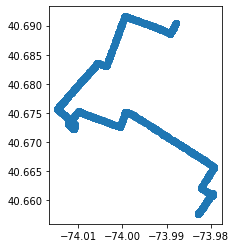

In [8]:
b_gdf.plot()

In [9]:
bk = ox.io.load_graphml('bk.graphml')

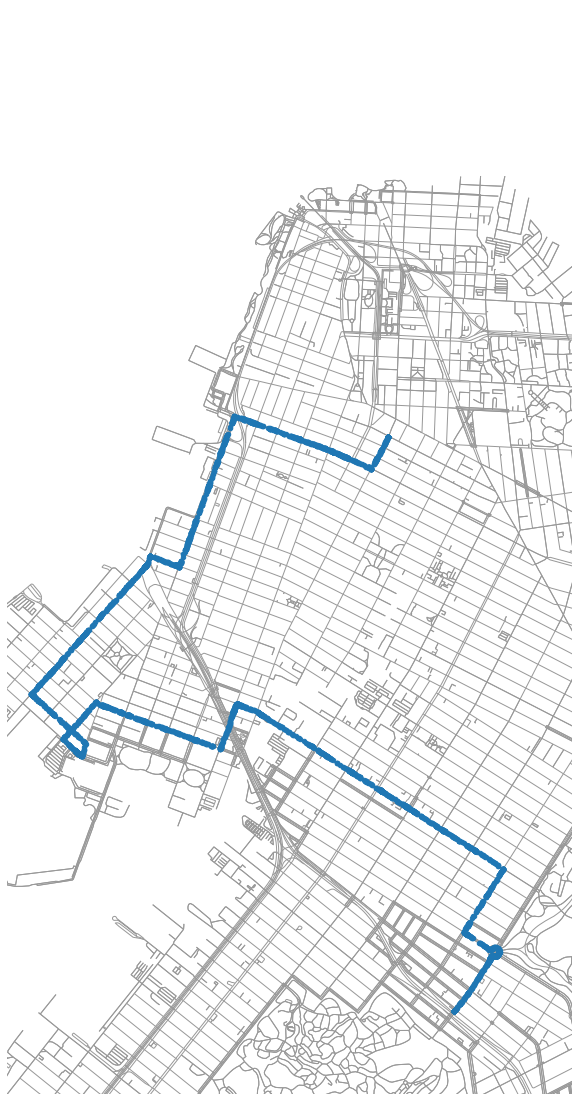

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(bk, ax=ax, bgcolor=None, node_size=0, bbox=(40.71501, 40.65289, -73.97407, -74.01660), show=False, close=False)
b_gdf.plot(ax=ax, zorder=20, markersize=20)
plt.show()

In [337]:
class Trajectory:
    def __init__(self, points):
        self.points = points
        self.df = pd.DataFrame(points, columns=['lon', 'lat', 'time'])

In [338]:
trajectories = []
curr_bus_id = None
curr_x = None
curr_trajectory = []
LENGTH_THRESHOLD = 10
for i in range(0, len(b_gdf)):
    row = b_gdf.iloc[i]
    lat = row['latitude']
    lon = row['longitude']
    time = row['datetime']
    
    if curr_x == None and curr_bus_id == None:
        curr_x = row['x']
        curr_bus_id = row['bus_id']
        if curr_x == 0:
            curr_trajectory.append((lon, lat, time))
    elif row['bus_id'] == curr_bus_id:
        if row['x'] == curr_x:
            if row['x'] == 0:
                curr_trajectory.append((lon, lat, time))
        else:
            if row['x'] == 1:
                if len(curr_trajectory) > LENGTH_THRESHOLD:
                    trajectories.append(Trajectory(curr_trajectory))
                curr_trajectory = []
            curr_x = row['x']
    else:
        if len(curr_trajectory) > LENGTH_THRESHOLD:
            trajectories.append(Trajectory(curr_trajectory))
        curr_trajectory = []
        curr_bus_id = row['bus_id']
        curr_x = row['x']
        if curr_x == 0:
            curr_trajectory.append((lon, lat, time))
if len(curr_trajectory) > LENGTH_THRESHOLD:
    trajectories.append(Trajectory(curr_trajectory))
display(len(trajectories))

53

In [339]:
def get_geoms(G):
    return ox.utils_graph.graph_to_gdfs(G, nodes=False)['geometry']

def get_rtree(G, geoms):
    # build the r-tree spatial index by position for subsequent iloc
    rtree = RTreeIndex()
    for pos, bounds in enumerate(geoms.bounds.values):
        rtree.insert(pos, bounds)
    return rtree

In [340]:
def k_nearest_edges(rtree, geoms, x, y, k=3):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    return dists_df.nsmallest(k, 'dist', keep='first').reset_index(drop=True)

In [341]:
bk_geoms = get_geoms(bk)
bk_rtree = get_rtree(bk, bk_geoms)

In [342]:
for trajectory in tqdm(trajectories):
    trajectory.k_nearest_edges = [k_nearest_edges(bk_rtree, bk_geoms, p[0], p[1]) for p in trajectory.points]

100%|██████████| 53/53 [01:05<00:00,  1.23s/it]


In [424]:
def get_all_paths(G, trajectory, path_threshold=10):
    all_paths = []
    all_paths_set = set()

    for k in tqdm(range(0, len(trajectory.k_nearest_edges) - 1)):
        kne0 = trajectory.k_nearest_edges[k]
        kne1 = trajectory.k_nearest_edges[k + 1]
        for i in range(0, len(kne0)):
            for j in range(0, len(kne1)):
                n0u = kne0.loc[i, 'u']
                n0v = kne0.loc[i, 'v']
                n1u = kne1.loc[j, 'u']
                n1v = kne1.loc[j, 'v']
                
                path0 = ox.distance.shortest_path(G, n0v, n1u)
                path1 = ox.distance.shortest_path(G, n1v, n0u)
                
                for path in [path0, path1]:
                    if path is None or len(path) < 2:
                        continue
                
                    if len(path) < path_threshold:
                        hash_path = str(path)
                        if hash_path not in all_paths_set:
                            all_paths.append(path)
                            all_paths_set.add(hash_path)
    return all_paths
           

In [ ]:
for trajectory in tqdm(trajectories):
    trajectory.all_paths = get_all_paths(bk, trajectory)

  6%|▌         | 3/53 [00:09<02:44,  3.29s/it]

In [357]:
def get_all_edges(trajectory):
    all_edges = []
    all_edges_set = set()
    
    for path in trajectory.all_paths:
        for i in range(0, len(path) - 1):
            edge = [path[i], path[i + 1]]
            hash_edge = str(edge)
            if hash_edge not in all_edges_set:
                all_edges.append(edge)
                all_edges_set.add(hash_edge)
                
    return all_edges
    
for trajectory in trajectories:
    trajectory.all_edges = get_all_edges(bk, trajectory)

In [358]:
subgraph_edges = []
subgraph_edges_set = set()

for trajectory in trajectories:
    for edge in trajectory.all_edges:
        hash_edge = str(edge)
        if hash_edge not in subgraph_edges_set:
            subgraph_edges.append(edge)
            subgraph_edges_set.add(hash_edge)

In [559]:
def create_route_subgraph(edges):
    node_set = set()
    graph = nx.MultiDiGraph()
    
    for edge in edges:
        u = edge[0]
        v = edge[1]
        if u not in node_set:
            node_set.add(u)
            graph.add_node(u, **bk.nodes[u])
        if v not in node_set:
            node_set.add(v)
            graph.add_node(v, **bk.nodes[v])
        graph.add_edge(u, v)
        
    graph.graph['crs'] = CRS_PLOT
    return graph

route_subgraph = create_route_subgraph(subgraph_edges)

In [360]:
route_gdf = gpd.read_file(f'{EXPORTS_DIR}/{ROUTE.lower()}_stops.shp').rename(columns={'stop_lon': 'lon', 'stop_lat': 'lat'})
route_start = route_gdf.iloc[0][['lon', 'lat', 'geometry']]
route_end = route_gdf.iloc[-1][['lon', 'lat', 'geometry']]
route_start_end_gdf = route_gdf.iloc[[0, -1]]
route_start = (route_start['lon'], route_start['lat'])
route_end = (route_end['lon'], route_end['lat'])

In [361]:
sg_geoms = get_geoms(route_subgraph)
sg_rtree = get_rtree(route_subgraph, sg_geoms)

In [362]:
kne_start = k_nearest_edges(sg_rtree, sg_geoms, route_start[0], route_start[1], k=10)
kne_end = k_nearest_edges(sg_rtree, sg_geoms, route_end[0], route_end[1], k=10)

In [631]:
def get_kne_shortest_path(kne0, kne1):
    paths = []
    for i in range(0, len(kne0)):
        for j in range(0, len(kne1)):
            n0u = kne0.loc[i, 'u']
            n0v = kne0.loc[i, 'v']
            n1u = kne1.loc[j, 'u']
            n1v = kne1.loc[j, 'v']
            path0 = ox.distance.shortest_path(route_subgraph, n0v, n1u, weight='c_length')
            path1 = ox.distance.shortest_path(route_subgraph, n1v, n0u, weight='c_length')
            for path in [path0, path1]:#, path2, path3]:
                if path is not None:
                    paths.append(path)
    return path

In [379]:
b0_gdf = b_gdf[b_gdf['x'] == 0]
b0_points = list(b0_gdf[['longitude', 'latitude']].to_records(index=False))
len(b0_points)

4819

In [408]:
def get_dist_squared(p, q):
    return (p[0] - q[0]) ** 2 + (p[1] - q[1])

def get_closest_point_index(p, points):
    closest_index = 0
    closest_dist = 10000
    for i in range(0, len(points)):
        dist = get_dist_squared(p, points[i])
        if dist < closest_dist and dist > 0:
            closest_index = i
            closest_dist = dist
    return closest_index

In [410]:
points = b0_points.copy()
p0 = route_start
jt = [] # joined trajectory
for i in tqdm(range(0, len(points))):
    i0 = get_closest_point_index(p0, points)
    p0 = points[i0]
    del points[i0]
    jt.append(p0)

100%|██████████| 4819/4819 [00:32<00:00, 148.02it/s]


In [412]:
jtt = [tuple(x) + (0,) for x in jt]
joined_trajectory = Trajectory(jtt)

In [416]:
joined_trajectory.k_nearest_edges = [k_nearest_edges(sg_rtree, sg_geoms, p[0], p[1]) for p in tqdm(joined_trajectory.points)]

100%|██████████| 4819/4819 [01:07<00:00, 71.13it/s]


In [425]:
joined_trajectory.all_paths = get_all_paths(route_subgraph, joined_trajectory, path_threshold=3)

100%|██████████| 4818/4818 [00:04<00:00, 1099.06it/s]


In [428]:
joined_trajectory.all_edges = get_all_edges(joined_trajectory)

jt_subgraph_edges = []
jt_subgraph_edges_set = set()

for edge in joined_trajectory.all_edges:
    hash_edge = str(edge)
    if hash_edge not in jt_subgraph_edges_set:
        jt_subgraph_edges.append(edge)
        jt_subgraph_edges_set.add(hash_edge)

jt_subgraph = create_route_subgraph(jt_subgraph_edges)

In [578]:
k_edges = [k_nearest_edges(sg_rtree, sg_geoms, p[0], p[1], k=2) for p in tqdm(joined_trajectory.points)]



  0%|          | 0/4819 [00:00<?, ?it/s]

  0%|          | 5/4819 [00:00<01:39, 48.53it/s]

  0%|          | 12/4819 [00:00<01:24, 57.11it/s]

  0%|          | 18/4819 [00:00<01:22, 57.89it/s]

  1%|          | 25/4819 [00:00<01:19, 60.03it/s]

  1%|          | 31/4819 [00:00<01:19, 59.91it/s]

  1%|          | 38/4819 [00:00<01:17, 61.39it/s]

  1%|          | 45/4819 [00:00<01:17, 61.70it/s]

  1%|          | 52/4819 [00:00<01:17, 61.79it/s]

  1%|          | 59/4819 [00:00<01:18, 60.78it/s]

  1%|▏         | 66/4819 [00:01<01:17, 61.35it/s]

  2%|▏         | 73/4819 [00:01<01:17, 61.61it/s]

  2%|▏         | 80/4819 [00:01<01:16, 62.35it/s]

  2%|▏         | 87/4819 [00:01<01:15, 62.56it/s]

  2%|▏         | 94/4819 [00:01<01:15, 62.31it/s]

  2%|▏         | 101/4819 [00:01<01:17, 61.24it/s]

  2%|▏         | 108/4819 [00:01<01:15, 62.01it/s]

  2%|▏         | 115/4819 [00:01<01:15, 61.97it/s]

  3%|▎         | 122/4819 [00:02<01:17, 60.56it/s]

  3%|▎         | 129/4819 [00:02<01

In [674]:
nx.set_edge_attributes(route_subgraph, 0, 'c')
 
max_c = 0
for edge in k_edges:
    for i in range(0, len(edge)):
        u = int(edge.loc[i, 'u'])
        v = int(edge.loc[i, 'v'])
        c = route_subgraph[u][v][0]['c'] + 1
        if c > max_c and c < 100:
            max_c = c
        route_subgraph[u][v][0]['c'] = c

for edge in route_subgraph.edges:
    u = edge[0]
    v = edge[1]
    d = bk[u][v][0]['length']
    c = route_subgraph[u][v][0]['c']
    x = (c / (max_c * 0.2)) * d
    c_length = d - min(x, d * 0.8)
    route_subgraph[u][v][0]['c_length'] = c_length


In [675]:
route = get_kne_shortest_path(kne_start, kne_end)

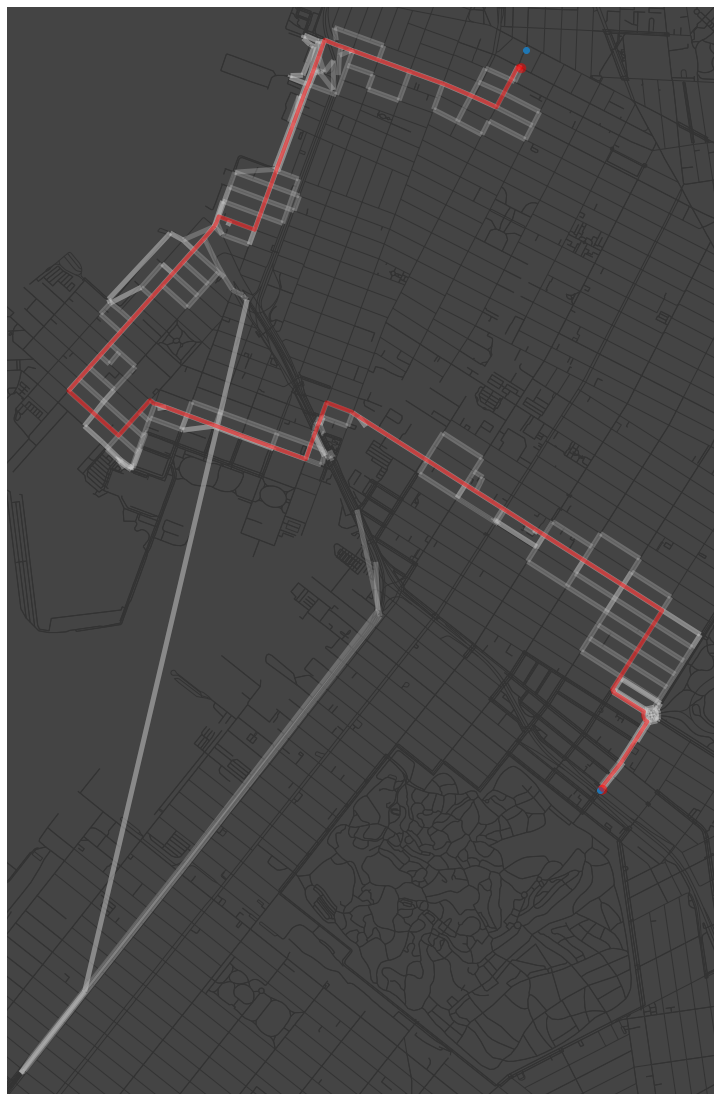

In [676]:
fig, ax = plt.subplots(figsize=(30, 20))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#333')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#ccc', edge_linewidth=5, edge_alpha=0.3)
ox.plot_graph_route(bk, route, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#00c', edge_linewidth=5, edge_alpha=1.0)
route_start_end_gdf.plot(ax=ax)
ax.set_facecolor('#444')